## What we expect to see
I don't want to manually define the value of each index of $p[i]$ and $c[i,j,k]$ in `eqs` every time. That would require me to know the size of $Np$ and $Nc$ in advance, and hardcode the `eqs` accordingly. Instead, here is a vectorized version. To check whether the reported equations are correct, I have also created some diagrams to help keep track of the terms.

![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_1.png?raw=true)
![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_2.png?raw=true)

## Equations we would expect
This final diagram shows the equation would expect for $\frac{dp(t)_1}{dt}$ (sum along the green columns, subtract the sum along the yellow rows).
![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_3.png?raw=true)

In [1]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=2

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] # notice that we must specify the number of corridors (layers) in the *last* index

@parameters α[1:Np]
@parameters β[1:Nc]
@parameters d[1:Np]

#define the corridor flux matrices
#notice the use of `.` notation before each arithmetic operation, but NOT before `=`

EnFlx(p,c,d,α,β) = exp.(-α .* β .* c) .* p .* d
ExFlx(c,β) = exp.(-β.*c).*c

#define equations
#notice there are only two equations, regardless of the size of Np or Nc

eqs = [
    D.(p) ~ [sum(ExFlx(c,β[1])[:,i,:]) for i in 1:Np] .- [sum(EnFlx(p,c,d,α[1],β[1])[i,:,:]) for i in 1:Np],
    D.(c) ~ collect(-ExFlx(c,β[1]) + EnFlx(p,c,d,α[1],β[1])),
]
#=
  Notice we only used "collect()" in the equation for D.(c). 
  For D.(p), we summed over the columns of the EnFlx matrix and over the columns of the ExFlx matrix, 
  then took their difference. If you don't do this (summing), you will get an error because you will be 
  attempting to save an object of shape (2,2,1) into an object of shape (2,).
=#

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 10 equations
Unknowns (10):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 1, 1]
  (c(t))[2, 1, 1]
  (c(t))[1, 2, 1]
  (c(t))[2, 2, 1]
⋮
Parameters (3):
  β[1]
  α[1]
  d

## Fast pipeline (call from helper functions)
Let's see if we can do all of this faster, in a more streamlined way.

In [40]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

2×2×2 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  40.0
 40.0     1.0e9

[:, :, 2] =
  1.0e9  40.0
 40.0     1.0e9

0.4166666666666667
C_jam:


2×2×2 Array{Float64, 3}:
[:, :, 1] =
 1.0e-9  0.025
 0.025   1.0e-9

[:, :, 2] =
 1.0e-9  0.025
 0.025   1.0e-9

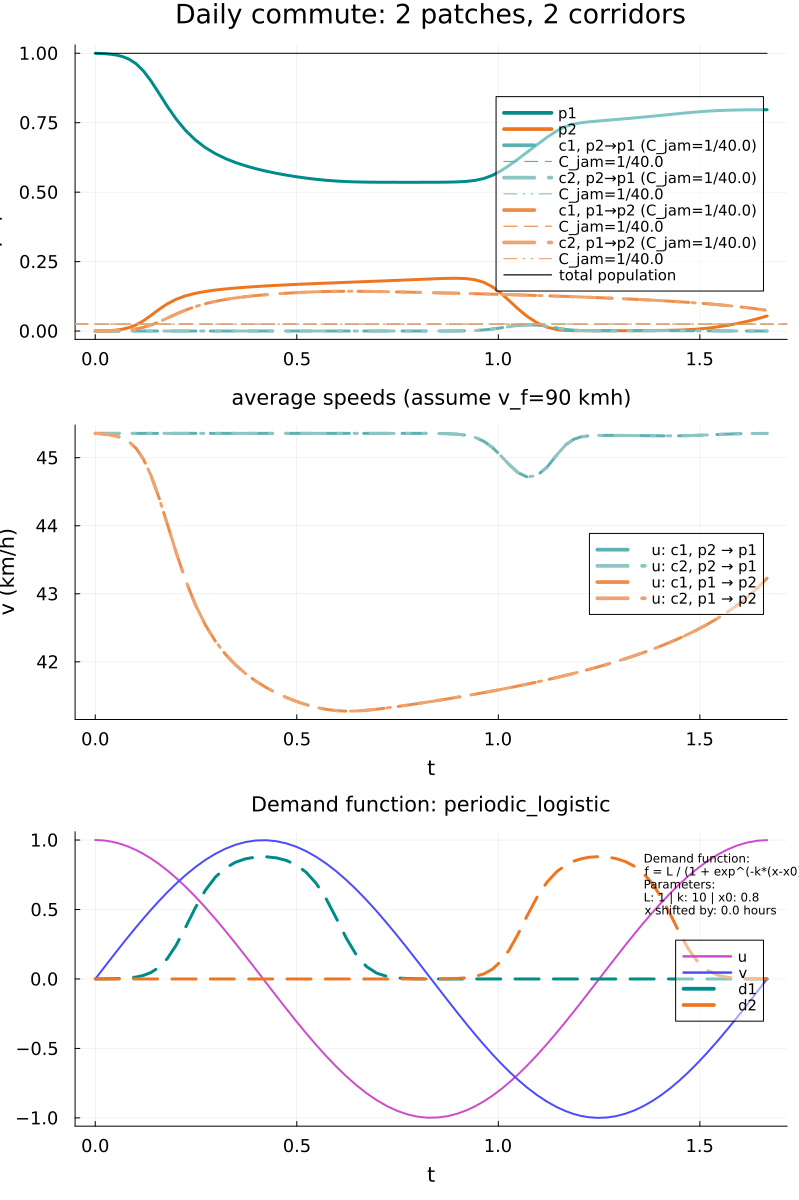

In [140]:
## Practice and play!
Np = 2
Nc = 2
# Set initial conditions
pm = [1.0; 0.0]
cm = zeros(Np,Np,Nc)
cm[1,2,1] = 0.00
cm[2,1,1] = 0.00
my_u = 1
my_v = 0

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = fill(1e9, Np, Np, Nc) #ones(2,2,Nc)    # Inverse road capacity (for now, assume same for all corridors)
# PROBLEM: cars are disappearing into the self-connected corridors. Very high β helps, but doesn't fix
# Can't fill with Inf because then the initial conditions often have a Inf * 0, which gives NaN and breaks the solver
# Using 1e9 works for now, but will it always work?

# Interesting behavior with my_β[1,2,1] = 40, my_β[1,2,2] = 60, my_β[2,1,1] = 15, my_β[2,1,2] = 30 and my_period=my_t_end=1440. Travellers seem to get stuck in the orange corridors?
my_β_base = 10
my_β[1,2,1] = my_β_base * 4 #4 #15
my_β[1,2,2] = my_β_base * 4 #6 #40
my_β[2,1,1] = my_β_base * 4 #1.5 #15
my_β[2,1,2] = my_β_base * 4 #3 #40
display(my_β)
my_d = [1; 0]  # Fraction of population desiring to leave patch i
base_t_end = 240
my_t_end = 100
my_period = my_t_end #1440 # Do these have to always be the same? (I guess not if I want to show multiple days)
# QUESTION
# How do I figure out what to put for t_end? Why doesn't doubling t_end just stretch everything out?
# I guess increasing t_end doesn't change the step size? So somehow more change happens in the same amount of time??
demand_function = "periodic_logistic"

# Arguments for demand functionm
my_L = 1 #0.6
my_k = 10 #10
my_x0 = 0.8 #0.8

# Try scaling up my_β
#my_β .= my_β .* (my_t_end / base_t_end)
println(my_t_end / base_t_end)

model, prob, sol, plt = HelpFuncs.build_symbolic_model_diurnal(Np=Np, Nc=Nc, pm=pm, cm=cm, my_u=my_u, my_v=my_v, my_α=my_α, my_β=my_β, d_version = demand_function, my_period = my_period, t_end = my_t_end, my_L=my_L, my_k=my_k, my_x0=my_x0)
savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_my_β_base_$my_β_base" * "_t_end_$my_t_end.png")
display(plt)

In [144]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

In [145]:
## Practice and play!
Np = 2
Nc = 1
# Set initial conditions
pm = [1.0; 0.0]
cm = zeros(Np, Np, Nc)
cm[1,2,1] = 0.00
cm[2,1,1] = 0.00
my_u = 1
my_v = 0

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β_base = 10
my_β = my_β_base*ones(Np, Np, Nc)    # Inverse road capacity (for now, assume same for all corridors)
 # Used to be 15 (in demo for poster) but had to decrease to 10 once I fixed the leaky corridors
my_β[[CartesianIndex(i, i, k) for i in 1:Np, k in 1:Nc]] .= 1e9

display(my_β)

my_period = 1440
my_t_end = 1440 #my_period
demand_function = "periodic_logistic"

# Arguments for demand functionm
my_L = 0.6 #0.6
my_k = 100 #10
my_x0 = 0.99 #0.8
my_shift = 1 * 60
my_x_pos = 0.65
my_y_pos = 0.8

model, prob, sol, plt = HelpFuncs.build_symbolic_model_diurnal_NEW(Np=Np, Nc=Nc, 
    my_kp=pm, my_kc=cm, my_u=my_u, my_v=my_v, my_α=my_α, my_kc_jam=my_β, 
    γ_version = demand_function, my_period = my_period, t_end = my_t_end, my_L=my_L, 
    my_k=my_k, my_x0=my_x0, my_shift=my_shift, x_pos=my_x_pos, y_pos=my_y_pos)
if demand_function == "periodic_logistic"
    savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_my_β_base_$my_β_base" * "_t_end_$my_t_end" * "_L_$my_L" * "_k_$my_k" * "_x0_$my_x0" * "_shift_$my_shift" * ".png")
else
    savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_my_β_base_$my_β_base" * "_t_end_$my_t_end.png")
end
display(plt)
display(prob)

2×2×1 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  10.0
 10.0     1.0e9

LoadError: UndefKeywordError: keyword argument `my_kp` not assigned

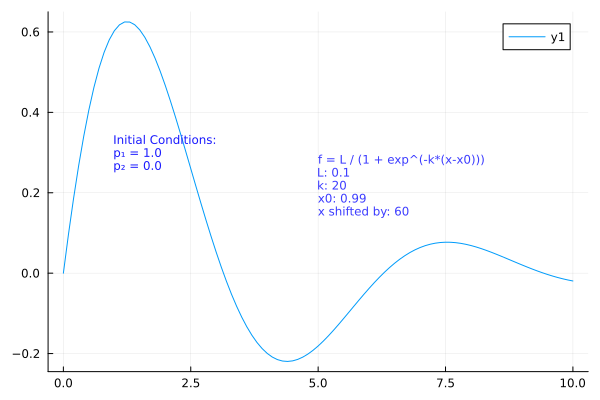

In [123]:
x = 0:0.1:10
y = exp.(-x/3) .* sin.(x)
plt3 = plot(x, y)

plt3 = annotate!(plt3, 1, 0.3, 
        text("Initial Conditions:\np₁ = 1.0\np₂ = 0.0", 
             :left, 8, :black, RGBA(0.1, 0.1, 1, 1)))

param_text = """
f = L / (1 + exp^(-k*(x-x0)))
L: $my_L
k: $my_k
x0: $my_x0
x shifted by: $my_shift
"""

x_pos = 0.5
y_pos = 0.5
# Use relative positioning (0-1 scale)
xlims = Plots.xlims(plt3)
ylims = Plots.ylims(plt3)
x_actual = xlims[1] + (xlims[2] - xlims[1]) * x_pos
y_actual = ylims[1] + (ylims[2] - ylims[1]) * y_pos

plt3 = annotate!(plt3, (x_actual, y_actual,
    text(param_text,
        :left, 8,
        :black,
        RGBA(0.1, 0.1, 1, 0.85))))  # Semi-transparent white background


In [110]:
model, prob, sol, plt = HelpFuncs.build_symbolic_model_diurnal(Np=Np, Nc=Nc, pm=pm, cm=cm, my_u=my_u, my_v=my_v, my_α=my_α, my_β=my_β, d_version = demand_function, my_period = my_period, t_end = my_t_end, my_L=my_L, my_k=my_k, my_x0=my_x0)

f₀ = prob.f(prob.u0, prob.p, 0.0)
display(f₀)

2 timesteps
C_jam:


┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/tey0W/src/integrator_interface.jl:628


2×2×1 Array{Float64, 3}:
[:, :, 1] =
 1.0e-9     0.0333333
 0.0333333  1.0e-9

2


2-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [NaN, NaN]


demand



2-element Vector{Vector{Float64}}:
 [0.18601531132343252, 0.18601531132343252]
 [0.1860209115126103, 0.1860097112270962]

8-element Vector{Float64}:
  0.0
  0.004363323129985824
 -0.37203062264686504
  0.0
  0.18601531132343252
  0.0
  0.18601531132343252
  0.0

In [104]:
model

Model model with 8 equations
Unknowns (8):
  u(t)
  v(t)
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 1, 1]
  (c(t))[2, 1, 1]
⋮
Parameters (3):
  period
  α[1]
  β

## Playing with additional patches

In [52]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

3×3×1 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  40.0    30.0
 20.0     1.0e9  30.0
 20.0    40.0     1.0e9

898 timesteps


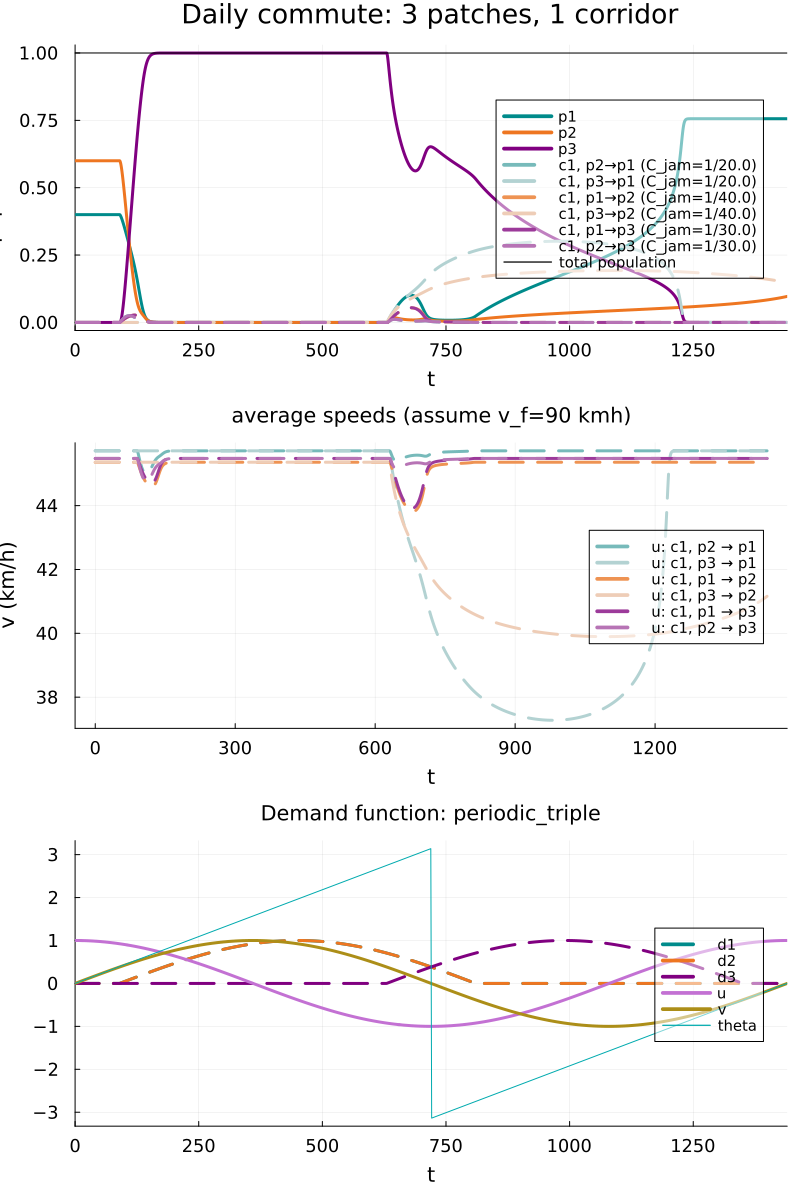

In [54]:
## Practice and play!
Np = 3
Nc = 1
# Set initial conditions
pm = [0.4; 0.6; 0.0]
cm = zeros(Np, Np, Nc)
my_u = 1
my_v = 0

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
#my_β = fill(1e9, Np, Np, Nc)
#my_β[1,2,1] = 15; my_β[2,1,1] = 15
#my_β[1,3,1] = 15; my_β[3,1,1] = 15
#my_β[2,3,1] = 15; my_β[3,2,1] = 15
my_β = 40*ones(Np, Np, Nc)
my_β[[CartesianIndex(i, 1, k) for i in 1:Np, k in 1:Nc]] .= 20
my_β[[CartesianIndex(i, 2, k) for i in 1:Np, k in 1:Nc]] .= 40
my_β[[CartesianIndex(i, 3, k) for i in 1:Np, k in 1:Nc]] .= 30
my_β[[CartesianIndex(i, i, k) for i in 1:Np, k in 1:Nc]] .= 1e9

display(my_β)
my_d = [1; 1; 0]  # Fraction of population desiring to leave patch i
base_t_end = 240
my_t_end = 1440
my_period = my_t_end #1440 # Do these have to always be the same? (I guess not if I want to show multiple days)
demand_function = "periodic_triple"

model, prob, plt = HelpFuncs.build_symbolic_model_diurnal(Np=Np, Nc=Nc, pm=pm, cm=cm, my_u=my_u, my_v=my_v, my_α=my_α, my_β=my_β, d_version = demand_function, my_period = my_period, t_end = my_t_end)
savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Np_$Np" * "_Nc_$Nc" * "_t_end_$my_t_end.png")
display(plt)